# A multimodal DBM, jointly modelling SNP and gene expression data

In this example a multimodal DBM is trained on genomic data from patients with acute myeloid leukemia (AML). The examined data set consists of data from 308 patients with SNP measurements, 319 patients with gene expression measurements and 26 patients with both measurements.

For training the multimodal DBM, the [BoltzmannMachines](https://github.com/stefan-m-lenz/BoltzmannMachines.jl) Julia package is employed. It is shown how the resulting model can be used for dimensionality reduction.

The data for executing the example code is attached. It has been extracted from the following sources:

[1] Hieke-Schulz, S. (2016). *SNP data from a clinical cohort of acute myeloid leukemia patients*. Harvard Dataverse.
https://doi.org/10.7910/DVN/JUMDLX

[2] Hieke, S. et. al. (2016). *Integrating multiple molecular sources into a clinical risk prediction signature by extracting complementary information*. BMC Bioinformatics. https://doi.org/10.1186/s12859-016-1183-6

## Preparations
The following code requires Julia 1.0 and the packages `BoltzmannMachines` and `BoltzmannMachinesPlots`.
The packages can be installed with the following commands:

In [ ]:
using Pkg
Pkg.add("BoltzmannMachines")
Pkg.add("BoltzmannMachinesPlots")

Now all the required packages can be loaded:

In [34]:
using BoltzmannMachines       # requires package version 1.1
using BoltzmannMachinesPlots  # requires package version 1.0

using DelimitedFiles
using Random

With the functions from the standard package `DelimitedFiles`, the data is read from the prepared CSV files. There are three files for three types of patients:
* For some patients there is only SNP data available, 
* for some there is only gene expression data,
* and for some there is both.

In [35]:
snpdata = readdlm("snpdata.csv", ','; header = true)[1]
gepdata = readdlm("gepdata.csv", ','; header = true)[1]
combsnpsgeps = readdlm("combSnpsGeps.csv", ','; header = true)[1];

## Training an RBM on SNP data (containing categorical values)

Encode the 0/1/2-valued SNPs into 00/01/10-valued data as input for the `Softmax0BernoulliRBM`:

In [36]:
snpdata01 = oneornone_encode(snpdata, 3)
combsnpsgeps = hcat(oneornone_encode(combsnpsgeps[:, 1:size(snpdata, 2)], 3),
    intensities(combsnpsgeps[:, (size(snpdata, 2)+1):end]));

Then train a `Softmax0BernoulliRBM` with the SNP data.

The data is split into training and test data and then used for monitoring during the training.

The `upfactor` and `downfactor` are set for the later use of the RBM as a first layer in the multimodal DBM. They account for the fact that the visible layer is only connected to one other layer, in contrast to the hidden RBM layer, which will be connected to two layers in the DBM, namely the visible layer and the second hidden layer.

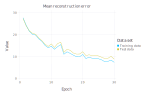

In [37]:
Random.seed!(1)
monitor1 = Monitor()
snpdata01train, snpdata01test = splitdata(snpdata01, 0.1)
snpdatadict = DataDict("Training data" => snpdata01train, "Test data" => snpdata01test)
snprbm = fitrbm(snpdata01train, categories = 3, upfactor = 2.0, downfactor = 1.0,
      epochs = 30,
      monitoring = (rbm, epoch) ->
            monitorreconstructionerror!(monitor1, rbm, epoch, snpdatadict))
plotevaluation(monitor1)

## Training an RBM on gene expression data

For feeding the data to a `BernoulliRBM`, the gene expression data is transformed into the interval [0,1]. The values are thereby treated as intensities:

In [38]:
gepintensities = intensities(gepdata);

Train a normal `BernoulliRBM` with the intensities ( = probabilities) as a first layer for the DBM.

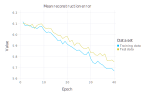

In [39]:
Random.seed!(1)
monitor2 = Monitor()
gepdatatrain, gepdatatest = splitdata(gepintensities, 0.1)
gepdatadict = DataDict("Training data" => gepdatatrain, "Test data" => gepdatatest)
geprbm = fitrbm(gepdatatrain, upfactor = 2.0, downfactor = 1.0,
      learningrate = 0.002,
      epochs = 40,
      monitoring = (rbm, epoch) ->
            monitorreconstructionerror!(monitor2, rbm, epoch, gepdatadict))
plotevaluation(monitor2)

## Training a multimodal DBM with both SNP data and gene expression data

Now train a multimodal DBM using only the patients that have both SNP and gene expression measurements:

The RBMs that have been trained for the input layer are used as pretrained building blocks in the first partitioned layer.
During the joint training as a DBM, the variational lower bound of the log-likelihood is estimated via annealed importance sampling and used for monitoring.

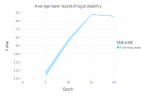

In [40]:
jointmonitor = Monitor();
jointdatadict = DataDict("Training data" => combsnpsgeps)
Random.seed!(1)
mdbm = fitdbm(combsnpsgeps,
      pretraining = [
            TrainPartitionedLayer([
               # use the pretrained RBMs in the first layer
               TrainLayer(startrbm = snprbm, epochs = 0);
               TrainLayer(startrbm = geprbm, epochs = 0)]
               );
            TrainLayer(nhidden = 10);
            TrainLayer(nhidden = 2)
      ],
      learningratepretraining = 0.005,
      learningrate = 0.002,
      epochs = 20,
      monitoring = (dbm, epoch) ->
            begin
               if epoch % 5 == 0 # monitor only every few epochs to save some time
                  monitorlogproblowerbound!(jointmonitor, dbm, epoch, jointdatadict)
               end
            end)
plotevaluation(jointmonitor; sdrange = 1.0)

## Use for dimensionality reduction

Because of the missing values in either SNP or gene expression data, the `meanfield` approach for calculating the activation cannot be used for dimensionality reduction in this particular example. But it is possible to estimate the activation via conditional Gibbs sampling in our case.

For this we define the following function, which estimates the mean activations in the last hidden layer of a DBM by  sampling conditionally on a given range of variables. 

In [41]:
function meanhidden(bm::AbstractBM, data::Matrix{Float64},
      range = 1:size(data, 2);
      ngensamples::Int = 500)

   mapreduce(i ->
         begin
            particles = initparticles(bm, size(data, 1))
            particles[1][:, range] .= data
            # Conditional gibbs sampling, return only last hidden layer
            gibbssamplecond!(particles, bm, range)[end]
         end, +, 1:ngensamples) ./ ngensamples
end

meanhidden (generic function with 2 methods)

We can  use this function to estimate the mean hidden activations that is induced by the different measurement modalities. The activations are then displayed as a scatter plot.

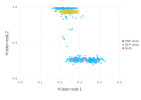

In [42]:
snprange = 1:size(snpdata01, 2)
geprange = snprange[end] .+ (1:size(gepdata, 2))
Random.seed!(1);

hidden = vcat(
   meanhidden(mdbm, snpdata01, snprange),
   meanhidden(mdbm, gepintensities, geprange),
   meanhidden(mdbm, combsnpsgeps))

scatterhidden(hidden,
      opacity = 0.5,
      labels = vcat(
            repeat(["SNP data"], size(snpdata01,1)),
            repeat(["GEP data"], size(gepdata,1)),
            repeat(["Both"], size(combsnpsgeps,1))))

Interpretation of the scatter plot above: 

The representation of the data with latent features divides the patients with only SNP measurements clearly into two groups.
The patients with only gene expression measurements seem to be similar to one of these subgroups.
The patients with both measurements are divided among those subgroups and each patient can be clearly assigned to one of them.
From this you can conclude that the multimodal DBM has not just separated the patients with SNP and gene expression data 
but it has instead extracted more meaningful imformation.